In [3]:
# load what we need
library(survival)
library(survminer)
library(drc)
library(tidyverse)
library(coxphf)

In [16]:
supplementation_survival <- read.csv("supplementation_survival.csv")
str(supplementation_survival)

'data.frame':	320 obs. of  18 variables:
 $ bee_code : chr  "Hive1_NC_1" "Hive1_NC_2" "Hive1_NC_3" "Hive1_NC_4" ...
 $ pot_code : chr  "Hive1_NC" "Hive1_NC" "Hive1_NC" "Hive1_NC" ...
 $ diet     : chr  "Nektapoll" "Nektapoll" "Nektapoll" "Nektapoll" ...
 $ infection: chr  "non" "non" "non" "non" ...
 $ hive     : int  1 1 1 1 1 1 1 1 1 1 ...
 $ treatment: chr  "Nektapoll-Control" "Nektapoll-Control" "Nektapoll-Control" "Nektapoll-Control" ...
 $ day_0    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ day_1    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ day_2    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ day_3    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ day_4    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ day_5    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ day_6    : int  0 1 1 1 1 1 1 1 1 1 ...
 $ day_7    : int  0 1 1 1 1 1 1 1 1 1 ...
 $ day_8    : int  0 1 1 1 1 1 1 1 1 1 ...
 $ day_9    : int  0 0 1 1 1 1 1 1 1 1 ...
 $ event    : int  1 1 0 0 0 0 0 0 0 0 ...
 $ dod      : int  6 9 9 9 9 9 9 9 9 9 ...


In [37]:
# convert hive to factor
supplementation_survival$hive <- factor(supplementation_survival$hive)
supplementation_survival$treatment <- factor(supplementation_survival$treatment)
head(supplementation_survival)

,bee_code,pot_code,diet,infection,hive,treatment,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,event,dod
,<chr>,<chr>,<chr>,<chr>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Hive1_NC_1,Hive1_NC,Nektapoll,non,1,Nektapoll-Control,1,1,1,1,1,1,0,0,0,0,1,6
2,Hive1_NC_2,Hive1_NC,Nektapoll,non,1,Nektapoll-Control,1,1,1,1,1,1,1,1,1,0,1,9
3,Hive1_NC_3,Hive1_NC,Nektapoll,non,1,Nektapoll-Control,1,1,1,1,1,1,1,1,1,1,0,9
4,Hive1_NC_4,Hive1_NC,Nektapoll,non,1,Nektapoll-Control,1,1,1,1,1,1,1,1,1,1,0,9
5,Hive1_NC_5,Hive1_NC,Nektapoll,non,1,Nektapoll-Control,1,1,1,1,1,1,1,1,1,1,0,9
6,Hive1_NC_6,Hive1_NC,Nektapoll,non,1,Nektapoll-Control,1,1,1,1,1,1,1,1,1,1,0,9


## 1. Using Cox Proportional Hazards to monitor effect of supplementation on survival over 9 days

### 1a - Create propertion dataframe collapsed by pot

In [24]:
# group data by pot
supplementation_pot <- subset(supplementation_survival, select = -c(bee_code, dod, event))
supplementation_pot <- supplementation_pot %>% group_by(infection, diet, hive, pot_code, treatment) %>% summarise_all(list("sum" = sum))

# convert frequencies to proportions
supplementation_pot[, -(1:5)] <- sweep(supplementation_pot[, -(1:5)], unlist(supplementation_pot[, "day_0_sum"]), MARGIN = 1, "/")

In [25]:
supplementation_pot

infection,diet,hive,pot_code,treatment,day_0_sum,day_1_sum,day_2_sum,day_3_sum,day_4_sum,day_5_sum,day_6_sum,day_7_sum,day_8_sum,day_9_sum
<chr>,<chr>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Nosema,Nektapoll,1,Hive1_NI,Nektapoll-Infected,1,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.95
Nosema,Nektapoll,2,Hive2_NI,Nektapoll-Infected,1,1,1.00,1.00,1.00,1.00,0.95,0.95,0.95,0.90
Nosema,Nektapoll,3,Hive3_NI,Nektapoll-Infected,1,1,0.95,0.95,0.85,0.80,0.80,0.80,0.75,0.75
Nosema,Nektapoll,4,Hive4_NI,Nektapoll-Infected,1,1,1.00,1.00,1.00,1.00,0.95,0.90,0.90,0.85
Nosema,Sucrose,1,Hive1_SI,Sucrose-Infected,1,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
Nosema,Sucrose,2,Hive2_SI,Sucrose-Infected,1,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.95
Nosema,Sucrose,3,Hive3_SI,Sucrose-Infected,1,1,1.00,1.00,1.00,0.95,0.95,0.95,0.95,0.95
Nosema,Sucrose,4,Hive4_SI,Sucrose-Infected,1,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
non,Nektapoll,1,Hive1_NC,Nektapoll-Control,1,1,1.00,1.00,1.00,1.00,0.95,0.95,0.95,0.90


### 1b - Make summary survival tables form the pot tables

In [27]:
supplementation.treatment = subset(supplementation_pot, select = -c(diet, hive, pot_code, infection))
supplementation.treatment.sum <- supplementation.treatment %>% group_by(treatment) %>% summarise_all(list("mean" = mean))
supplementation.treatment.sum
# from this, it looks as if Nektapoll-Infected treatment had lower survival than sucrose-infected,
# will have to see if this is significant

treatment,day_0_sum_mean,day_1_sum_mean,day_2_sum_mean,day_3_sum_mean,day_4_sum_mean,day_5_sum_mean,day_6_sum_mean,day_7_sum_mean,day_8_sum_mean,day_9_sum_mean
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Nektapoll-Control,1,1,1.0000,1.0000,1.0000,1.0000,0.9875,0.9750,0.9625,0.9375
Nektapoll-Infected,1,1,0.9875,0.9875,0.9625,0.9500,0.9250,0.9125,0.9000,0.8625
Sucrose-Control,1,1,0.9875,0.9875,0.9750,0.9750,0.9625,0.9625,0.9625,0.9625
Sucrose-Infected,1,1,1.0000,1.0000,1.0000,0.9875,0.9875,0.9875,0.9875,0.9750


## 3. Plotting the survival probability data

Warning message in .add_surv_median(p, fit, type = surv.median.line, fun = fun, :
“Median survival not reached.”


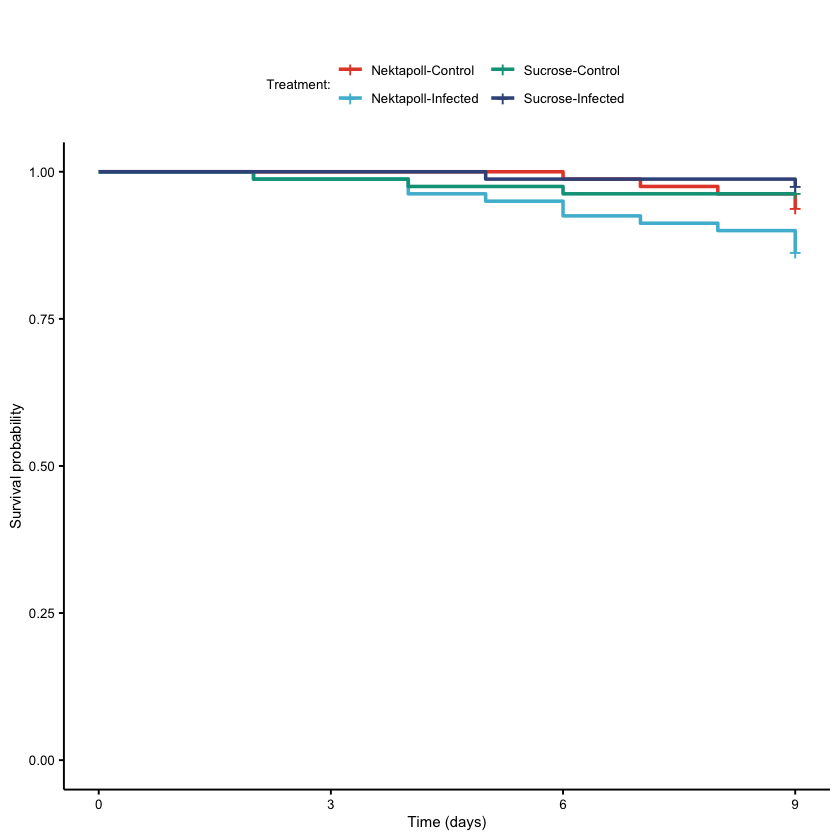

In [34]:
# now we have summarised the data by treatment, it is now time to analyse it
# we can run fit function plots to look at the data
survfit.supplementation <- survfit(Surv(dod, event) ~ treatment, data = supplementation_survival) 

# then creat a Kaplan-Meier curve with the nektapoll treatments
km.supplementation <- ggsurvplot(survfit.supplementation, data = supplementation_survival, pval = FALSE,
                           title = "", font.y = 9,font.x =9, font.tickslab = 8, xlab = "Time (days)", font.legend=8, legend.labs =
                             c("Nektapoll-Control", "Nektapoll-Infected", "Sucrose-Control", "Sucrose-Infected"), 
                           legend.title = "Treatment:", time.inc = 1, xlim = c(0,9), palette = "npg", linetype = "solid", 
                           surv.median.line = "h", legend = "top", break.time.by = 3) + guides(colour = guide_legend(nrow = 2))
km.supplementation
# not very informative, such small differences in survival that it's hard to make out. Only thing that's clear
# is that Nektapoll-Infected has the lowest survival

## 4. Statistical Comparison of the treatments

In [38]:
# gonna relevel the treatments so that sucrose control appears first
supplementation_survival$treatment <- relevel(supplementation_survival$treatment, ref = "Sucrose-Control")

In [40]:
# run cox regression to understand if the different treatments cause significant losses compared to the control
supplementation.coxph <- coxph(Surv(dod, event) ~ treatment + hive, data = supplementation_survival)
supplementation.coxph

Call:
coxph(formula = Surv(dod, event) ~ treatment + hive, data = supplementation_survival)

                               coef exp(coef) se(coef)      z      p
treatmentNektapoll-Control   0.4832    1.6212   0.7304  0.662 0.5083
treatmentNektapoll-Infected  1.3620    3.9039   0.6515  2.090 0.0366
treatmentSucrose-Infected   -0.4308    0.6500   0.9129 -0.472 0.6370
hive2                        0.5294    1.6980   0.7303  0.725 0.4685
hive3                        1.2063    3.3412   0.6671  1.808 0.0705
hive4                        0.3119    1.3660   0.7638  0.408 0.6830

Likelihood ratio test=13.63  on 6 df, p=0.03401
n= 320, number of events= 21 

In [42]:
# check we don't violate assumptions
coxassump = cox.zph(supplementation.coxph)
coxassump
# all over 0.05, so no problems here with violation

          chisq df    p
treatment  5.58  3 0.13
hive       4.93  3 0.18
GLOBAL    10.64  6 0.10

regression shows that it seems none of the treatments have significantly reduced survival compared to the control. Suggesting that potentially pollen supplementation does not increase survival of nosema